In [1]:
import clrs
import jax
import numpy as np

rng = np.random.RandomState(42)
rng_key = jax.random.PRNGKey(rng.randint(2**31))
NUM_SAMPLES = 1000

# Create samplers
sampler, spec = clrs.build_sampler(
        "bellman_ford",
        seed=rng.randint(2**31),
        num_samples=NUM_SAMPLES,
        length=7,
        )
# batch_size = feedback.outputs[0].data.shape[0]
# new_rng_key, rng_key = jax.random.split(rng_key)


2025-02-26 14:16:42.516319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740579402.527423  109911 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740579402.530350  109911 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph_from_adjacency_matrix(adjacency_matrix, weight_matrix=None):
    """
    Visualizes a graph with explicit arrows and labeled edge weights (adjacent).

    Args:
        adjacency_matrix: Adjacency matrix (NumPy array).
        weight_matrix: Optional weight matrix (NumPy array).
    """

    adjacency_matrix = np.array(adjacency_matrix)
    if adjacency_matrix.shape[0] != adjacency_matrix.shape[1]:
        raise ValueError("Adjacency matrix must be square.")
    num_nodes = adjacency_matrix.shape[0]

    if weight_matrix is None:
        weight_matrix = np.ones_like(adjacency_matrix)
    else:
        weight_matrix = np.array(weight_matrix)
        if weight_matrix.shape != adjacency_matrix.shape:
            raise ValueError("Weight matrix must have the same dimensions.")

    directed_graph = nx.DiGraph()
    undirected_graph = nx.Graph()

    for i in range(num_nodes):
        directed_graph.add_node(i)
        undirected_graph.add_node(i)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                if adjacency_matrix[i, j] != 0:
                    weight = round(weight_matrix[i, j], 2)
                    if adjacency_matrix[j, i] != 0:
                        if i < j:
                            undirected_graph.add_edge(i, j, weight=weight)
                    else:
                        directed_graph.add_edge(i, j, weight=weight)

    pos = nx.spring_layout(undirected_graph)  # Layout based on undirected

    plt.figure(figsize=(8, 6))

    # Draw undirected edges (no arrows)
    nx.draw_networkx_edges(undirected_graph, pos, edge_color='gray', width=2, arrows=False)
    edge_labels_undirected = nx.get_edge_attributes(undirected_graph, 'weight')
    # Use label_pos and rotate for adjacent labels
    nx.draw_networkx_edge_labels(undirected_graph, pos, edge_labels=edge_labels_undirected,
                                 label_pos=0.3, rotate=True)

    # Draw directed edges with explicit arrows
    nx.draw_networkx_edges(directed_graph, pos, edge_color='black', width=1,
                           arrowstyle='->', arrowsize=15)
    edge_labels_directed = nx.get_edge_attributes(directed_graph, 'weight')
    # Use label_pos and rotate for adjacent labels
    nx.draw_networkx_edge_labels(directed_graph, pos, edge_labels=edge_labels_directed,
                                 label_pos=0.3, rotate=True)

    nx.draw_networkx_nodes(directed_graph, pos, node_color='skyblue', node_size=500)
    nx.draw_networkx_labels(directed_graph, pos)

    plt.title("Graph Visualization")
    plt.axis('off')
    plt.show()

In [3]:
feedback = sampler.next()

In [4]:
import random
item = random.randint(1, NUM_SAMPLES) - 1

In [5]:
weights = feedback.features.inputs[2].data[item]
adj = feedback.features.inputs[3].data[item]

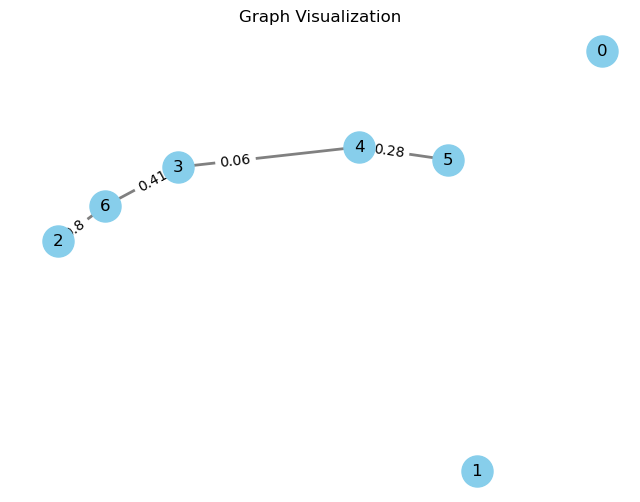

In [6]:
visualize_graph_from_adjacency_matrix(adj, weights)

In [7]:
feedback.outputs[0].data[item] # pi ground truth

array([0, 1, 6, 4, 5, 5, 3])

In [8]:
feedback.features.inputs

[DataPoint(name="pos",	location=node,	type=scalar,	data=Array(1000, 7)),
 DataPoint(name="s",	location=node,	type=mask_one,	data=Array(1000, 7)),
 DataPoint(name="A",	location=edge,	type=scalar,	data=Array(1000, 7, 7)),
 DataPoint(name="adj",	location=edge,	type=mask,	data=Array(1000, 7, 7))]

In [107]:
feedback.features.inputs[1].data[item] # starting value

array([0., 0., 0., 1., 0., 0., 0.])

In [108]:
spec

{'pos': ('input', 'node', 'scalar'),
 's': ('input', 'node', 'mask_one'),
 'A': ('input', 'edge', 'scalar'),
 'adj': ('input', 'edge', 'mask'),
 'pi': ('output', 'node', 'pointer'),
 'pi_h': ('hint', 'node', 'pointer'),
 'd': ('hint', 'node', 'scalar'),
 'msk': ('hint', 'node', 'mask'),
 'upd_pi': ('hint', 'node', 'pointer'),
 'upd_d': ('hint', 'node', 'scalar')}

In [109]:
feedback.features.hints[0].data[:,item,:] #pi hints

array([[0., 1., 2., 3., 4., 5., 6.],
       [0., 1., 2., 3., 3., 3., 6.],
       [0., 5., 5., 3., 3., 3., 6.],
       [1., 5., 5., 3., 3., 3., 2.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [110]:
feedback.features.hints[1].data[:,item,:] #current best distances

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.48810113,
        0.48536958, 0.        ],
       [0.        , 0.97659785, 0.84423094, 0.        , 0.48810113,
        0.48536958, 0.        ],
       [1.24105017, 0.97659785, 0.84423094, 0.        , 0.48810113,
        0.48536958, 1.39730722],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]])

In [111]:
feedback.features.hints[2].data[:,item,:] #msk for nodes explored at each step

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [112]:
feedback.features.hints[3].data[:,item,:] #predecessors updated at each step

array([[-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1.,  3.,  3., -1.],
       [-1.,  5.,  5., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [113]:
feedback.features.hints[4].data[:,item,:] #distances updated at each step

array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        ,  0.48810113,
         0.48536958, -1.        ],
       [-1.        ,  0.97659785,  0.84423094, -1.        , -1.        ,
        -1.        , -1.        ],
       [ 1.24105017, -1.        , -1.        , -1.        , -1.        ,
        -1.        ,  1.39730722],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])